# Assignment 4
Training a simple neural net for relation classification.

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import warnings
import itertools
from transformers import BertTokenizer
from transformers import logging
from transformers import BertForSequenceClassification
from statistics import mean
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np 
import random
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from collections import namedtuple
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

logging.set_verbosity_error()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a touple, where the first element is the sentence string and the second the label (also represented as a sting). 

In [ ]:
# I built this by looking at the data. Is there a better way? we won't always have a data to look at.. 
tag_set = {
  'Component-Whole',
  'Content-Container',
  'Cause-Effect',
  'Entity-Destination',
  'Entity-Origin',
  'Instrument-Agency',
  'Member-Collection',
  'Message-Topic',
  'Product-Producer', 
  'Other'
}

def get_tag_for(sentence):
  for key in tag_set:
    if key in sentence:
      return key
  return 'Other'

In [ ]:
def transform_data(data):
  # The '\r' replacement are for cases where the data is acting odd, 
  # for instance when reading sentence 627 from the train-file 
  # "The <e1>sail</e1> had an important <e2>roach</e2> and had adjustable 
  # batten fittings on the leech and luff receptacles." for some kind of reason we get 
  # '<e2>roach<       /e2>'.
  return data.replace('\r', '').split('\n\n') 

def get_sentence_and_tag(complex_sentence):
  sentence_split = complex_sentence.split('\n')
  line, sentence = sentence_split[0].split('\t')
  sentence = sentence.strip('"')
  tag = get_tag_for(sentence_split[1])
  return sentence, tag

def read_data(filepath):
  data = []
  with open(filepath, "r") as file:
    fdata = file.read()
    fdata = transform_data(fdata)
    fdata = fdata[:-1] # The last object will be empty so we want to ignore it
    for complex_sentence in fdata:
      sentence, tag = get_sentence_and_tag(complex_sentence)
      data.append((sentence, tag))
    return data

In [ ]:
!git clone https://github.com/kfirbar/nlp-course

fatal: destination path 'nlp-course' already exists and is not an empty directory.


In [ ]:
# train
train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
idx = 47
print("Data size:", len(train))
print(train[idx][0])
print(train[idx][1])

Data size: 8000
As in the popular movie "Deep Impact", the action of the Perseid <e1>meteor shower</e1> is caused by a <e2>comet</e2>, in this case periodic comet Swift-Tuttle.
Cause-Effect


In [ ]:
# test
test = read_data('/content/nlp-course/TEST_FILE_FULL.TXT')
idx = 0
print("Data size:", len(test))
print(test[idx][0])
print(test[idx][1])
# test[0:10]

Data size: 2717
The most common <e1>audits</e1> were about <e2>waste</e2> and recycling.
Message-Topic


Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [ ]:
# Todo: maybe I should use the tagset here, and not the data.
def create_label_mapper(data):
  counter = 0
  tagger = {}
  for sentence, tag in data:
    if tag not in tagger:
      tagger[tag] = counter
      counter += 1
  
  return tagger

tagger = create_label_mapper(train)            

In [ ]:
# train_tagger
print(tagger)

{'Component-Whole': 0, 'Other': 1, 'Instrument-Agency': 2, 'Member-Collection': 3, 'Cause-Effect': 4, 'Entity-Destination': 5, 'Content-Container': 6, 'Message-Topic': 7, 'Product-Producer': 8, 'Entity-Origin': 9}


**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. The function also aggregate the samples into batches. BERT Uses pretrained tokanization and embedding. you can access the tokanization and indexing using the BertTokenizer class.

In [ ]:
def prepare_data(data, tokenizer, batch_size=8):
    batch = [[], []]

    for sample in data:
      sentence = sample[0]
      tag = sample[1]
      batch[0].append(sentence)
      batch[1].append(tagger[tag])

    max_len = 0
    for sent in batch[0]:
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      max_len = max(max_len, len(input_ids))

    input=[]
    attention=[]
    tags=batch[1]

    for sentence in batch[0]:
        encoded_dict = tokenizer(
        sentence,
        add_special_tokens = True,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = "pt",
        max_length = max_len
        )
        
        input.append(encoded_dict['input_ids'].to(device))
        attention.append(encoded_dict['attention_mask'].to(device))
    
    input_id=torch.cat(input, dim=0).to(device)
    atte=torch.cat(attention, dim=0).to(device)
    label_id=torch.tensor(tags).to(device)
    dataset = TensorDataset(input_id,atte,label_id)

    return DataLoader(
      dataset,
      sampler=SequentialSampler(dataset),
      batch_size=batch_size) ,dataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_sequences ,train_dataset = prepare_data(train, tokenizer)
test_sequences,test_dataset = prepare_data(test, tokenizer)

In [ ]:
##split train /Dev
def train_dev_dataloader(dataset):

# Create a 95-5 train-validation split.

# Calculate the number of samples to include in each set.
    train_size = int(0.95 * len(train_dataset))
    val_size = len(train_dataset) - train_size

# Divide the dataset by randomly selecting samples.
    train_data, val_data = random_split(train_dataset, [train_size, val_size])

    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

    train_dataloader = DataLoader(
                train_data,  # The training samples.
                sampler = RandomSampler(train_data), # Select batches randomly
                batch_size =8 # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_data, # The validation samples.
                sampler = SequentialSampler(val_data), # Pull out batches sequentially.
                batch_size = 8 # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

In [ ]:
train_data,validation_dataloader= ret_dataloader(train_dataset)

7,600 training samples
  400 validation samples


**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [ ]:
def get_parameters(params):
  param_list = list(params)
  p = param_list[-2][-1] ##p[-1] is the bias and it's all zeros
  return [p]

def init_model():
  model = BertForSequenceClassification.from_pretrained(
          "bert-base-uncased", 
          num_labels = len(tagger), 
          output_attentions = False, # Whether the model returns attentions weights.
          output_hidden_states = False, # Whether the model returns all hidden-states.
          )
  model.to(device)
  return model

model = init_model()

# Optimizer (ADAM is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.001)

**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [ ]:
def train_loop(model, n_epochs, train_data, optimizer,comment):
  # Loss function
  print('Start training:')
  criterion = nn.CrossEntropyLoss() # Loss function
  train_loss_array=[]
  train_loss_e=[]
  batch_size = 50
  
  print(train_data)
  
  for e in range(1, n_epochs + 1):
    train_loss = 0.0
    running_loss= 0.0
    print("")
    print('======== Epoch {:} / {:} ========'.format(e, n_epochs))
    print(comment)

    for i , batch in enumerate(train_data):
      input_ids = batch[0].to(device)
      input_mask = batch[1].to(device)
      labels = batch[2].to(device)
      model.zero_grad()        
      outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)

      loss =  criterion(outputs.logits, labels)

      optimizer.zero_grad() # Zero the gradients

      loss.backward()   # Perform a backward pass (backpropagation)

      optimizer.step()  # Update the parameters
      
      # statistics
      train_loss += loss.item()
      running_loss += loss.item()
      if i % batch_size == 0 and i > 1 :    
        train_loss_array.append(running_loss / batch_size)
        print('Batch {:>5,}  of  {:>5,} loss: {:}' .format( i ,len(train_data), running_loss / batch_size))
        running_loss = 0.0

   # calculate train loss for epoch
    train_loss_calc = train_loss / len(train_data)
    print('========Epoch {:} Loss {:} ========'.format(e,train_loss_calc))
    train_loss_e.append(train_loss_calc)

  return model, optimizer

In [ ]:
model_trained, optimizer = train_loop(model, 10, train_data, optimizer,"Train")
model, optimizer = train_loop(model_trained, 10, validation_dataloader, optimizer,"Dev")

Start training:

======== Epoch 1 / 10 ========
Train
Batch    50  of    950 loss: 2.385766966342926
Batch   100  of    950 loss: 2.2229510045051573
Batch   150  of    950 loss: 2.2323870968818667
Batch   200  of    950 loss: 2.1985343623161318
Batch   250  of    950 loss: 2.15387024641037
Batch   300  of    950 loss: 2.1752386260032655
Batch   350  of    950 loss: 2.138786907196045
Batch   400  of    950 loss: 2.196463992595673
Batch   450  of    950 loss: 2.0697077918052673
Batch   500  of    950 loss: 2.104599988460541
Batch   550  of    950 loss: 2.086870565414429
Batch   600  of    950 loss: 2.0948660874366762
Batch   650  of    950 loss: 2.038350718021393
Batch   700  of    950 loss: 2.0542921662330627
Batch   750  of    950 loss: 2.0359427905082703
Batch   800  of    950 loss: 1.999629328250885
Batch   850  of    950 loss: 1.9598525333404542
Batch   900  of    950 loss: 1.985708978176117
========Epoch 1 Loss 2.110216003970096 ========

======== Epoch 2 / 10 ========
Train
Batch 

**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
def evaluate(model, test_data):
  tags= list(tagger.keys())
  total = 0
  correct = 0
  confusion_matrix = torch.zeros(len(tags),len(tags))
  with torch.no_grad():
    for step , batch in enumerate(test_data):
          ##print("pass")
          input_ids = batch[0].to(device)
          input_mask = batch[1].to(device)
          labels = batch[2].to(device)
          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask,return_dict=True)
          logits = outputs.logits.to(device)
          pred_flat = torch.argmax(logits, dim=1)
          pred_flat = pred_flat.cpu().numpy()
          labels=labels.cpu().numpy()
          
          total += len(labels)
          correct += (pred_flat == labels).sum()
          
          for i in range(len(labels)):
                  confusion_matrix[pred_flat[i],labels[i]] += 1
  
  acc=correct / total
        
  return confusion_matrix,acc

In [ ]:
confusion_matrix,acc = evaluate(model,test_sequences)

In [ ]:
print("The Accuracy is:" , acc)

The Accuracy is: 0.43172616856827384


In [ ]:
##printing 
confusion_matrix=confusion_matrix.numpy()
tags= list(tagger.keys())
indexes= tags+["Total"]
num_of_tags=10
df = pd.DataFrame(data=np.zeros((num_of_tags+1,2)), index= indexes, columns=["precision","recall"])
TP_total ,FN_total,FP_total =0.0 ,0.0 ,0.0 
TP,FN,FP=0.0,0.0,0.0
for i in range(len(tags)):

    TP=confusion_matrix[i,i]
    FN=np.sum(confusion_matrix[:,i])-confusion_matrix[i,i]
    FP=np.sum(confusion_matrix[i,:])-confusion_matrix[i,i]

    if TP ==0 and FN ==0:
        recall=0.0
    recall = TP / (TP+FN)
    if TP ==0 and FP ==0:
        precision=0.0
    precision = TP / (TP+FP)
    
    df.loc[tags[i]]=[float(precision),float(recall)]

    TP_total += TP
    FN_total += FN
    FP_total += FP

total_recall=TP_total/(TP_total+FN_total)
total_precision=TP_total/(TP_total+FP_total)
df.loc[indexes[10]]=[float(total_precision),float(total_recall)]
display(df)

,precision,recall
Component-Whole,0.662162,0.314103
Other,0.230975,0.381057
Instrument-Agency,0.302326,0.333333
Member-Collection,0.566667,0.364807
Cause-Effect,0.712281,0.618902
Entity-Destination,0.466200,0.684932
Content-Container,0.795699,0.385417
Message-Topic,0.585366,0.459770
Product-Producer,0.337778,0.329004
Entity-Origin,0.352490,0.356589


**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS token for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

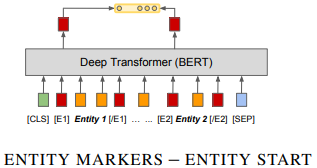

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
def get_max_len(sentences):
    max_len = 0
    for sentence in sentences:
      input_ids = tokenizer.encode(sentence, add_special_tokens=True)
      max_len = max(max_len, len(input_ids))
    return max_len

In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size = 8):
    batch = [[], []]
    input=[]
    attention=[]
    tags=[]
    markers_indices = []
    
    for sample in data:
      sentence = sample[0]
      tag = sample[1]
      batch[0].append(sentence)
      batch[1].append(tagger[tag])
    
    max_len = get_max_len(batch[0])
    vocab = tokenizer.get_vocab()

    for sentence, tag in zip(batch[0], batch[1]):
      encoded_dict = tokenizer(
        sentence,
        add_special_tokens = True,
        padding = "max_length",
        return_attention_mask = True,
        return_tensors = "pt",
        max_length = max_len
      )
      
      input.append(encoded_dict['input_ids'].to(device))
      attention.append(encoded_dict['attention_mask'].to(device))
      tags.append(tag)
      markers_indices.append([encoded_dict['input_ids'].tolist()[0].index(id) for id in [vocab['<e1>'], vocab['<e2>']]])

    dataset = TensorDataset(
        torch.cat(input, dim=0).to(device),
        torch.cat(attention, dim=0).to(device),
        torch.tensor(tags).to(device),
        torch.tensor(markers_indices).to(device)
    )

    return DataLoader(
        dataset = dataset,
        sampler = SequentialSampler(dataset),
        batch_size = batch_size)

In [ ]:
train_sequences = prepare_data_MTB(train, tokenizer)
test_sequences = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model_name):
      super().__init__()
      self.hidden_size = 768 # bert's default.
      self.model = init_model()
      self.model.classifier = nn.Linear(self.hidden_size, len(tagger))
      # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
      # self.model.classifier.bias.data.fill_(0.01) 
      self.model.resize_token_embeddings(len(tokenizer))
      self.max_pool = nn.MaxPool1d(kernel_size = 3, stride = 2, padding = 1)
      self.to(device)

    def forward(self, input, index, attention_mask, labels):
      bert = self.model.bert(
          input,
          attention_mask = attention_mask
          )
      maxpool = self.max_pool(bert[0])
      batch_size = input.shape[0]
      # make two layers from the original size
      tensor1 = torch.zeros((batch_size, int(self.hidden_size/2))).to(device)
      tensor2 = torch.zeros((batch_size, int(self.hidden_size/2))).to(device)
      
      for idx, seq in enumerate(maxpool):
        tensor1[idx] = seq[index[:,0][idx]]
        tensor2[idx] = seq[index[:,1][idx]]

      logits_layer = self.model.classifier(torch.cat((tensor1, tensor2), 1))
      loss = nn.CrossEntropyLoss()
      loss = loss(logits_layer.view(-1, self.model.num_labels), labels.view(-1))
      
      return SequenceClassifierOutput(
          loss = loss,
          logits = logits_layer,
          hidden_states = bert.hidden_states,
          attentions = bert.attentions
        )

In [ ]:
model_mtb = MTB('bert-base-uncased')

In [ ]:
def train_loop_MTB(model, n_epochs, train_data, optimizer, is_mtb = False):
  # Loss function
  print('Start training:')
  criterion = nn.CrossEntropyLoss() # Loss function
  train_loss_array=[]
  train_loss_e=[]
  batch_size = 50
  
  print(train_data)
  
  for e in range(1, n_epochs + 1):
    print("")
    print('======== Epoch {:} / {:} ========'.format(e, n_epochs))
    print('Training...')
    train_loss = 0.0
    running_loss= 0.0
    # model.train()

    for i, batch in enumerate(train_data):
      input_ids = batch[0].to(device)
      input_mask = batch[1].to(device)
      labels = batch[2].to(device)
      # model.zero_grad()
      
      if is_mtb:
        # self, input, index, attention, labels):
        outputs = model(
            input_ids,
            index = batch[3].to(device),
            attention_mask = input_mask,
            labels = labels)
      else:
        outputs = model(
            input_ids, 
            attention_mask = input_mask,
            token_type_ids = None, 
            labels=labels)

      loss =  criterion(outputs.logits, labels)
      
      optimizer.zero_grad() # Zero the gradients
      loss.backward()   # Perform a backward pass (backpropagation)
      optimizer.step()  # Update the parameters

      # statistics
      train_loss += loss.item()
      running_loss += loss.item()

      if i % batch_size == 0 and i > 1 :    
        train_loss_array.append(running_loss / batch_size)
        print('Batch {:>5,}  of  {:>5,} loss: {:}' .format( i ,len(train_data), running_loss / batch_size))
        running_loss = 0.0

   # calculate train loss for epoch
    train_loss_calc = train_loss / len(train_data)
    print('========Epoch {:} Loss {:} ========'.format(e,train_loss_calc))
    train_loss_e.append(train_loss_calc)

  return model, optimizer

In [ ]:
model_trained_mtb, optimizer = train_loop_MTB(model_mtb, 5, train_sequences, optimizer, True)

Start training:

======== Epoch 1 / 5 ========
Training...
Batch    50  of  1,000 loss: 2.373382611274719
Batch   100  of  1,000 loss: 2.3302900695800783
Batch   150  of  1,000 loss: 2.3285653495788576
Batch   200  of  1,000 loss: 2.3093593740463256
Batch   250  of  1,000 loss: 2.3300725412368775
Batch   300  of  1,000 loss: 2.332556757926941
Batch   350  of  1,000 loss: 2.33349326133728
Batch   400  of  1,000 loss: 2.3182434701919554
Batch   450  of  1,000 loss: 2.338885130882263
Batch   500  of  1,000 loss: 2.336110916137695
Batch   550  of  1,000 loss: 2.338385796546936
Batch   600  of  1,000 loss: 2.327881345748901
Batch   650  of  1,000 loss: 2.34012291431427
Batch   700  of  1,000 loss: 2.3287598657608033
Batch   750  of  1,000 loss: 2.3359047079086306
Batch   800  of  1,000 loss: 2.3073558712005617
Batch   850  of  1,000 loss: 2.3370355272293093
Batch   900  of  1,000 loss: 2.2999488258361818
Batch   950  of  1,000 loss: 2.2754599046707153
========Epoch 1 Loss 2.3216874792575837

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
def evaluate_MTB(model, test_data, is_mtb = True):
  tags = list(tagger.keys())
  total = 0
  correct = 0
  confusion_matrix = torch.zeros(len(tags),len(tags))

  with torch.no_grad():
    for step, batch in enumerate(test_data):
      input_ids = batch[0].to(device)
      input_mask = batch[1].to(device)
      labels = batch[2].to(device)
      
      if is_mtb:
        outputs = model(
            input_ids,
            index = batch[3].to(device),
            attention_mask = input_mask,
            labels = labels)
      else:
        outputs = model(
            input_ids, 
            token_type_ids = None, 
            attention_mask = input_mask)
        
      logits = outputs.logits.to(device)
      pred_flat = torch.argmax(logits, dim=1) # should we add a softmax here?
      pred_flat = pred_flat.cpu().numpy()
      labels=labels.cpu().numpy()
      
      total += len(labels)
      correct += (pred_flat == labels).sum()
      
    for i in range(len(labels)):
      confusion_matrix[pred_flat[i],labels[i]] += 1
  
    acc = correct / total
          
  return confusion_matrix, acc

In [ ]:
confusion_matrix, acc = evaluate_MTB(model_trained_mtb, test_sequences)

In [ ]:
print("The Accuracy is:" , acc)

The Accuracy is: 0.09017298490982702


**Good luck!**